---

# Pipeline de Dados - Bot Telegram API
GitHub: [Repositório Remoto](https://github.com/DevBrunoP/Pipeline_Telegram_AWS) <br>
Autor: Bruno Pereria

---

## 0\. Contexto

O intúito deste projeto foi a construção de um pipeline de dados efetua a coleta dados dos chats de um grupo do Telegram, faz a Ingestão, ETL, e por fim na aparesentação temos acesso aos dados já transformados e normalizados. As ferramentas utilizadas foram a linguagem Python, assim como o ambiente cloud AWS (S3, Athena, Lambda, etc.)

 - **Apresentação da arquitetura**

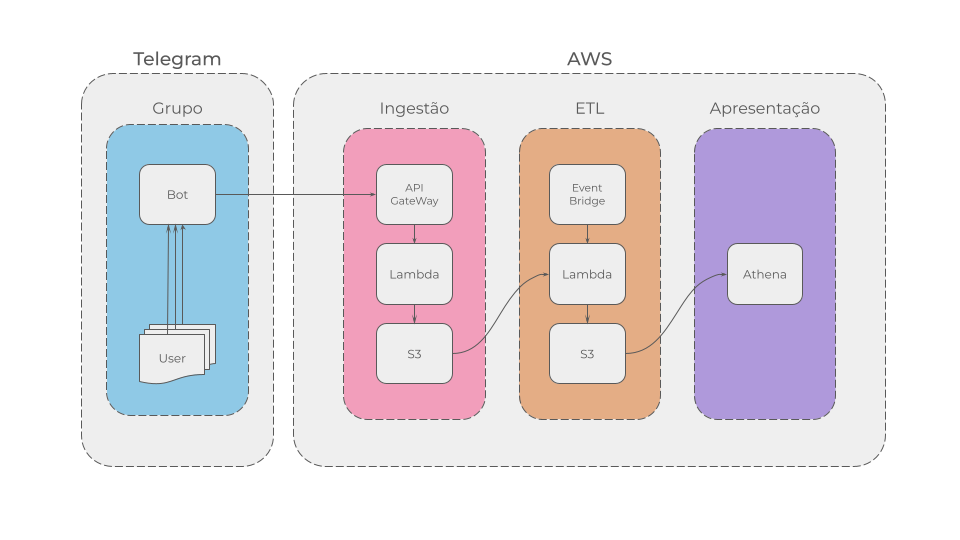

- **Explicação das ferramentas utilizadas**

**AWS S3**: Atua como o repositório principal para armazenar os dados em diferentes camadas do datalake, incluindo as etapas de dados brutos (raw) e dados enriquecidos (enriched), organizados em formato tabular para fácil acesso e consulta.

**AWS API Gateway**: Responsável por receber as mensagens captadas pelo bot do Telegram por meio de webhooks. Este componente serve como um gatilho para iniciar outros serviços da AWS, como o AWS Lambda, facilitando a automação do fluxo de dados.

**AWS Lambda**: Funciona como a inteligência do pipeline de dados. Ele processa as mensagens recebidas do bot, realizando a normalização e transformações necessárias para convertê-las em formato tabular. Além disso, o Lambda executa operações de data wrangling para preparar os dados antes de armazená-los no S3.

**AWS EventBridge**: Serve como o orquestrador do pipeline de dados, agendando e disparando a execução do fluxo de trabalho automaticamente com a periodicidade desejada (por exemplo, D-1, que indica a execução para o dia anterior).

**AWS IAM**: Garante o gerenciamento de permissões e políticas de segurança para os serviços, incluindo o controle de acesso do AWS Lambda, permitindo que ele interaja de forma segura com outros recursos da AWS, como S3 e API Gateway.

**AWS Athena**: Responsável por consultar e apresentar os dados já processados e enriquecidos na última etapa do pipeline. Permite que os usuários realizem análises ad-hoc diretamente nos dados armazenados no S3 usando SQL.

**Python**: Linguagem de programação utilizada para desenvolver as funções do AWS Lambda. Fornece a base para implementar a lógica de processamento, transformações de dados e integrações com outros serviços da AWS.

- **Aplicação prática**

A solução de pipeline de dados desenvolvida, pode trazer muitos benefícios em um cenário real. Além de fornecer insights significativos e relatórios para a apresentação ao usuário final, algumas perguntas que poderiam ser respondidas com base na análise exploratória de dados incluem:

- Qual o horário de maior atividade no grupo?
<br>*Identificar os horários em que os usuários mais interagem pode ajudar a planejar a moderação ou intervenções estratégicas.*

- Quais são os problemas ou dúvidas mais recorrentes? 
<br>*Com uma análise de palavras-chave e frequência, é possível determinar as principais questões levantadas, facilitando a criação de FAQs e material de suporte.*

- Quais são os tópicos mais discutidos ao longo do tempo? 
<br>*Realizar uma análise temporal dos temas pode ajudar a perceber mudanças nas preocupações e interesses dos usuários.*
- A interação do grupo está aumentando ou diminuindo?
<br>*Monitorar a atividade ao longo do tempo pode fornecer insights sobre o engajamento e a saúde do grupo, ajudando a ajustar estratégias de comunicação.*

- Quais são os sentimentos predominantes nas mensagens? 
<br>*Implementar uma análise de sentimento pode revelar se o grupo está positivo, negativo ou neutro em relação aos tópicos discutidos.*

- Quais usuários contribuem com respostas para as dúvidas alheias? 
<br>*Essa métrica pode destacar potenciais líderes ou colaboradores que ajudam a resolver dúvidas e manter o grupo ativo, assim como promover bonificações.*

- Qual o tempo médio de resposta para perguntas no grupo? 
<br>*Isso pode ser útil para medir a rapidez com que os usuários obtêm respostas, ajudando a melhorar o suporte e a comunicação.*

## 1\. Telegram

### I. BOT

No Telegram seguiremos o seguinte passo a passo:
- Criar um BOT com o BOTFather;
- Criar um grupo e adicionar nosso BOT recém criado como adminstrador;
- Retornar no BotFather e alterar a configuração `Allow Groups` para `Turn groups off` para nosso BOT não seja adicionado em outros grupos, afim de garantirmos algum tipo de consistência.

Pronto, as mensagens enviadas pelos membros do grupo serão ouvidas pelo BOT!

### II. API Telegram

Na documentação da API do Telegram, utilizaremos o método `getUpdates` que retornará as mensagens captadas pelo *bot*, esas mensagens ficamam armazenadas nos servidores do Telegram pelo período de 24h. Segue um exemplo do uso e do retorno abaixo:

A documentação da API do Telegram que pode ser encontrada através deste [link](https://core.telegram.org/bots/api)

```python
import requests
import json

url = f'https://api.telegram.org/bot{token}'
response = requests.get(url=f'{url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))
```

```JSON
{
  "ok": true,
  "result": [
    {
      "update_id": 1291203912, // Identificador exclusivo da atualização
      "message": {
        "message_id": 4, 
        "from": {
          "id": 92108190312, // ID do usuário
          "is_bot": false, // O usuário que mandou a mensagem é um BOT?
          "first_name": "Jose", // Nome do usuario
          "last_name": "Antonio", // Sobrenome do usuario
          "username": "JoseAntonio", 
          "language_code": "pt-br"
        },
        "chat": {
          "id": -92038420394, // ID único do grupo, esse número sempre será negativo
          "title": "Grupo Teste", // Nome do grupo
          "type": "supergroup"
        },
        "date": 1731778924, // Data no formato Timestamp
        "text": "Opa" // A mensagem que foi enviada
      }
    }
  ]
}
```

Essa estrutura inicial será utilizada para que possamos construir todas as demais camadas do nosso pipeline de dados, vamos lá?

## 2\. Ingestão

A etapa de **ingestão** é responsável, como seu o próprio nome diz, pela ingestão dos dados. De maneira geral, o dado ingerido é persistido(armazenado) no formato mais próximo do original, ou seja, nenhuma transformação é realizada em seu conteúdo ou estrutura. Como exemplo, dados de uma API *web* que segue o formato REST (*representational state transfer*) são entregues, logo, persistidos no formato JSON.

Para que seja possível esse tipo de **ingestão** seja possível, vamos utilizar um *webhook* (gancho *web*), ou seja, vamos redirecionar as mensagens automaticamente para outra API *web*, para isso configuraremos na AWS o `AWS API Gateway`(documentação neste [link](https://docs.aws.amazon.com/pt_br/apigateway/latest/developerguide/welcome.html)) que dentre suas diversas funcionalidades permite o redirecionamento do dado recebido para outros serviços da AWS, com isso vamos conecta-lo ao `AWS lambda`, que por sua vez, irá armazenar o dado em seu formato original (JSON) em um *bucket* do `AWS S3`.

### I. AWS S3

No S3 criaremos um Bucket no qual irá armazenar os dados sem nenhum tipo de transformação. Manterei a nomenclatura `datalake-raw`

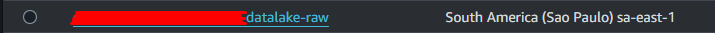

> **Nota**: 
> - Raw pois o dados está de fato 'cru', sem nenhum tipo de tratamento.
> - `Data lake` é o nome dado a um repositório de um grande volume dados. É organizado em zonas que armazenam replicadas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: *raw* e *enriched* ou *bronze*, *silver* e *gold*.

### II. Lambda

O `AWS Lambda` terá a função de ativamente armazenar as mensagens captadas pelo *bot* do **Telegram** em um *bucket* do `AWS S3`. Seguiremos o seguinte passo a passo para fazer essa etapa funcionar:

- Criaremos uma função lambda que opera da seguinte forma:
    - Recebe a mensagem no parâmetro `event`;
    - Verifica se a mensagem tem origem no grupo do **Telegram** correto (Há essa validação para evitar que alguém mande mensagens no privado para o BOT a caia na automação, validaremos se a origem da mensagem é exclusivamente do Grupo que criamos);
    - Armazena a mensagem no formato JSON no bucket do `AWS S3`;
    - Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de *bots* do **Telegram**.
- Configuraremos duas variáveis de ambiente:
    - `AWS_S3_BUCKET`: Bucket que criamos para armazenar os dados 'crus';
    - `TELEGRAM_CHAT_ID`: Id único do grupo que o BOT está.
- Adicionaremos a permissão para que o `AWS Lambda` consiga efetuar a escrita no *bucket* do `AWS S3`

---

- **Código da função Lambda**

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone, timedelta

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve, 
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET'] # Consome a variável de ambiente com o nome do Bucket do AWS S3
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID']) # Consome a variável de ambiente com o Id do grupo

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3)) # Configura uma timezome para o fuso horário de Brasília(GMT-3)
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')
  
  try:

    message = json.loads(event["body"]) # Para testar no AWS Lambda, você pode comentar essa linha e descomentar a de baixo
    #message = event

    if message == None or message == []:
      # Não foi enviada nenhuma mensagem no grupo
      return dict(statusCode="204") # Solicitação foi processada com sucesso, mas que não há dados a serem retornados
    
    else:
      chat_id = message["message"]["chat"]["id"]

      # Verifica se o código do chat é igual ao código do grupo que está na variável de ambiente
      if chat_id == TELEGRAM_CHAT_ID:

        with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
          json.dump(message, fp)

        client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      # Caso tenha dado errado, retorna o status code 500
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      # Caso tenha dado certo, retorna o status code 200
      return dict(statusCode="200")


- **Variáveis de Ambiente**

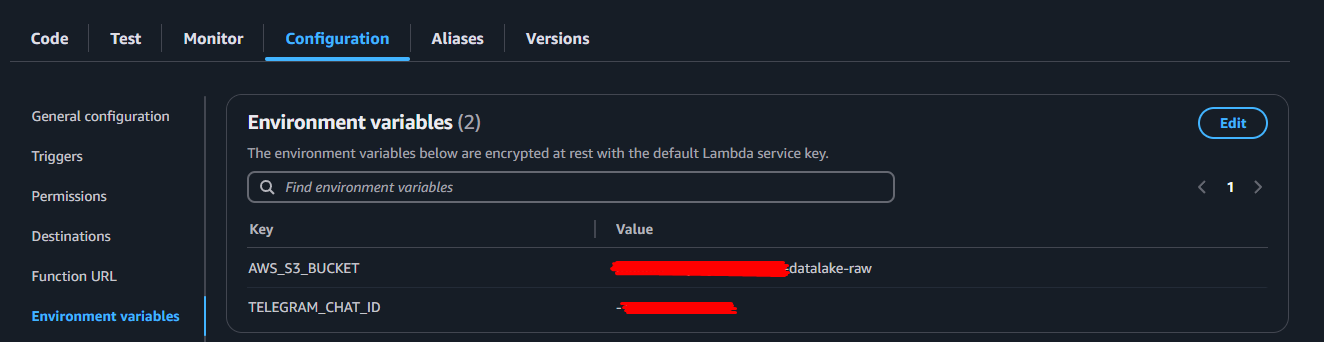

- **Permissões**

Para as permissões, a própria AWS nos fornece alguns templates já prontos de qual regra iremos fornecer o acesso, por segurança queremos apens que o Lambda tenha permissão de escrita a um Bucket especefíco. Como não há um template pronto para isso, criarei um do zero, segue o código JSON que utilizei para restringir apenas a escrita a um Bucket específico:

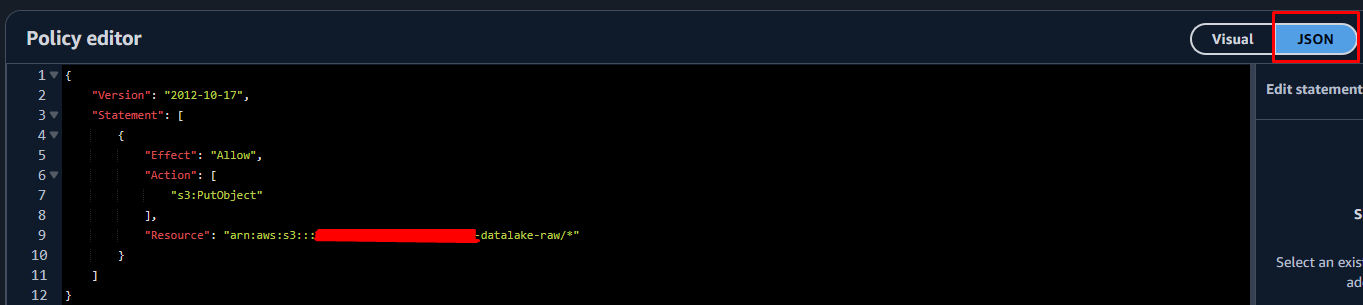

### II. API Gateway

Na etapa de **ingestão**, o `AWS API Gateway` tem a função de receber as mensagens captadas pelo *bot* do **Telegram**, enviadas via *webhook*, e iniciar uma função do `AWS Lambda`, passando o conteúdo da mensagem no seu parâmetro *event*. Para tanto vamos criar uma API e configurá-la como gatilho da função do `AWS Lambda` seguindo os passos abaixo:
- Acessar o `AWS API Gateway` e criar uma REST API;
- Configurar o Método POST;
- Habilitar o *Use Lambda Proxy integration*;
- Adicionar a função Lmabda que criamos no tópico anterior.
 - Por fim faremos o Deploy *Actions* -> *Deploy API*;

- **API Criada**

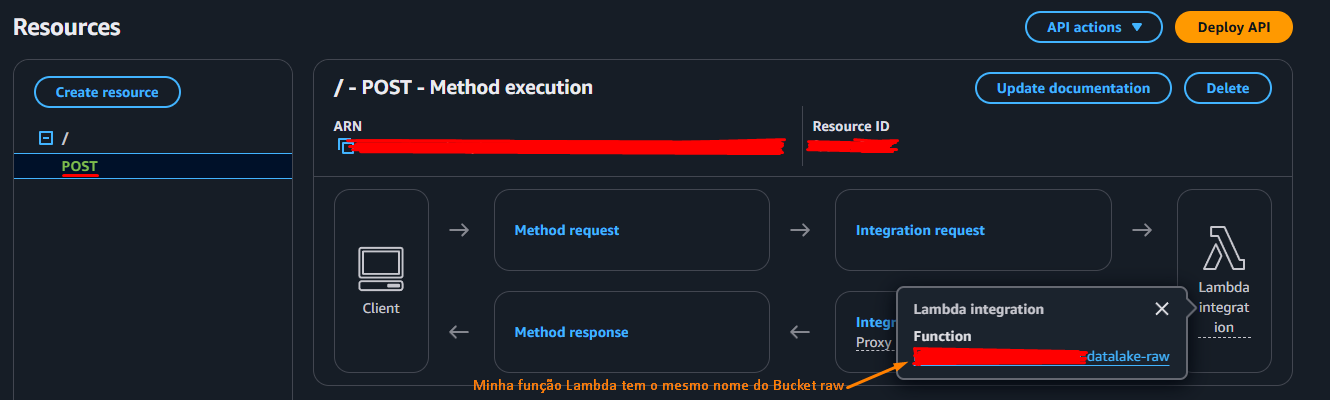

Ao final será gerado uma URL, configuraremos o *webhook* para redirecionar as mensagens para essa `url` do `AWS API Gateway`. O método `setWebhook` configura o redirecionamento das mensagens captadas pelo *bot* para o endereço *web* do parametro `url`.

> **Nota**: os métodos `getUpdates` e `setWebhook` são mutualmente exclusivos, ou seja, enquanto o *webhook* estiver ativo, o método `getUpdates` não funcionará. Para desativar o *webhook*, basta utilizar o método `deleteWebhook`.

In [ ]:
aws_api_gateway_url = 'url da API que criamos com o AWS API Gateway'
response = requests.get(url=f'{url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

```JSON
{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}
```

## 3\. ETL

A etapa de **extração, transformação e carregamento** (do inglês *extraction, transformation and load* ou **ETL**) é uma etapa abrangente responsável pela manipulação dos dados ingeridos de sistemas transacionais, ou seja, já persistidos em camadas cruas ou *raw* de sistemas analíticos. Os processos conduzidos nesta etapa variam bastante de acordo com a área da empresa, do volume/variedade/velocidade do dado consumido, etc. Contudo, em geral, o dado cru ingerido passa por um processo recorrente de *data wrangling* onde o dado é limpo, deduplicado, etc. e persistido com técnicas de particionamento, orientação a coluna e compressão. Por fim, o dado processado está pronto para ser analisado por profissionais de dados.

No projeto, as mensagens de um único dia, persistidas na camada cru, serão compactas em um único arquivo, orientado a coluna e comprimido, que será persistido em uma camada enriquecida. Além disso, durante este processo, o dado também passará por etapas de *data wrangling*.

Para isso, vamos utilizar uma função do `AWS Lambda` como motor de processamento e um *bucket* do `AWS S3` como camada enriquecida para a persistência do dado processado. Para garantir a recorrência, vamos configurar uma regra do `AWS Event Bridge` como gatilho diáro da função.

### I. AWS S3

Nessa etapa, criaremos um bucket no `AWS S3`, onde ele terá a função de passivamente armazenar as mensagens processadas de um dia em um único arquivo no formato Parquet, tendo em vista que é um ótimo formato para otimizar o armazenamento das informações no S3. Como padrão, irei adicionar o sufixo `-enriched` no nome do bucket (vamos seguir esse padrão para todos os serviços desta camada).

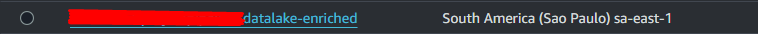

### II. AWS Lambda

Nessa etapa, o `AWS Lambda` terá a função de ler as mensagens persistidas na camada cru no *bucket* do `AWS S3`, efetuar o wrangling e persisti-las na camada enriquecida no *bucket-enriched* do `AWS S3` que acabamos de criar. Segue o passo a passo mais detalhado desta etapa:

- Criação de uma função lambda que:
    - Lista todos os arquivos JSON de uma única participação da camada crua de um *bucket* do `AWS S3`;
    - Para cada arquivo listado:
        - Faz o *download* do arquivo e carrega o conteúdo da mensagem;
        - Executa uma função de *data wrangling*;
        - Cria uma tabela do PyArrow e a contatena com as demais.
- Persiste a tabela no formato Parquet na camada enriquecida em um *bucket* do `AWS S3`;
- Configurar as variáveis de ambiente:
    - ``RAW_BUCKET``: Nome do bucket que criamos no tópico de Ingestão, que contém os dados sem nenhum tipo de transformação(cru);
    - ``ENRICHED_BUCKET``: Nome do bucket que acabamos de criar que iá conter os dados após o wrangling(enriched).
- Precisaremos ceder três permissões, uma de leitura(ao bucket raw), outra de escrita(ao bucket enriched) e um última para consultar o conteúdo do bucket raw;
- Precisaremos aumentar o timeout do tempo de execução do lambda;
- Por último mas não menos importante, será necessário criar uma layer, pois utilizamos a biblioteca pyarrow que não está instalada no ambiente do lambda.

- **Código da função Lambda**

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único 
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None
          
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False

- **Código da função Lambda de data wrangling**

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

 - **Variáveis de ambiente**

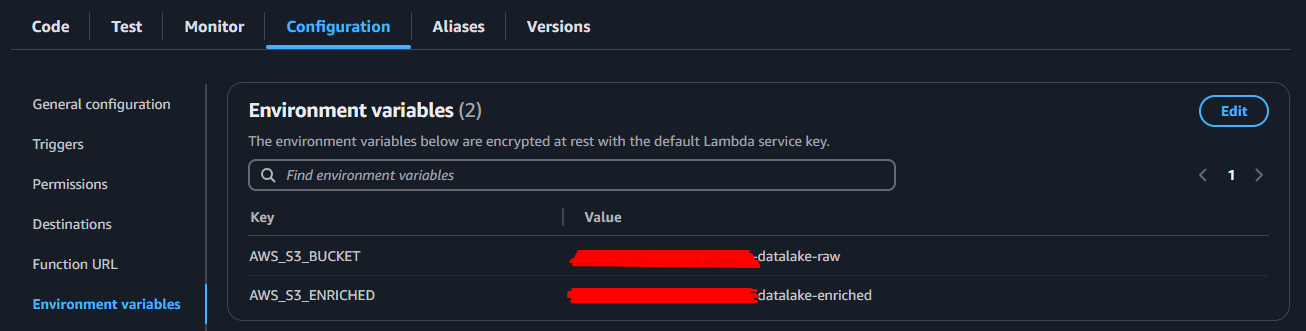

 - **Permissão**

Precisamos novamente adicionar uma permissão personalizada ao Lambda, mas dessa vez adicionaremos duas permissões a mais, ambas serão aplicadas ao bucket raw:
Uma deverá incluir a leitura, pois precisaremos acessar os dados brutos para podemos normalizá-los. O outr precisará incluir o uso do ``s3:ListBucket``. Essa permissão é necessária porque, no nosso código, existe uma linha que realiza a listagem dos objetos contidos no bucket, utilizando a função ``list_objects_v2``:

```Python
response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')
```

Essa operação requer acesso para ler os metadados do bucket, permitindo que o Lambda identifique os arquivos armazenados. Portanto, é fundamental conceder acesso de leitura ao bucket de dados brutos (raw) caso contrário gerará o seguinte erro: `(AccessDenied) when calling the ListObjectsV2 operation`.

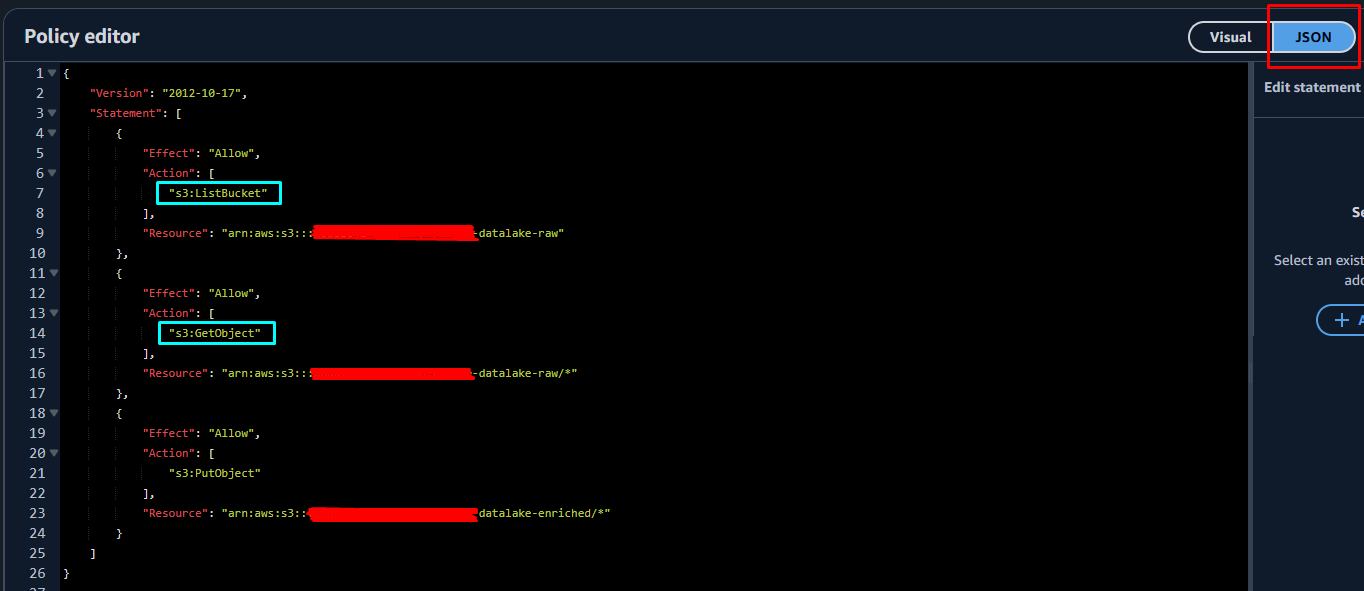

 - **Recursos**

O *timeout* padrão de funcões do `AWS Lambda` é de 3 segundos. Como lidamos com muitos IO (*input/output*) das informações, principalmente para lidar com leitura de escrita de arquivos no `AWS S3`, precisaremos aumentar o tempo para 5 minutos de timeout da função.

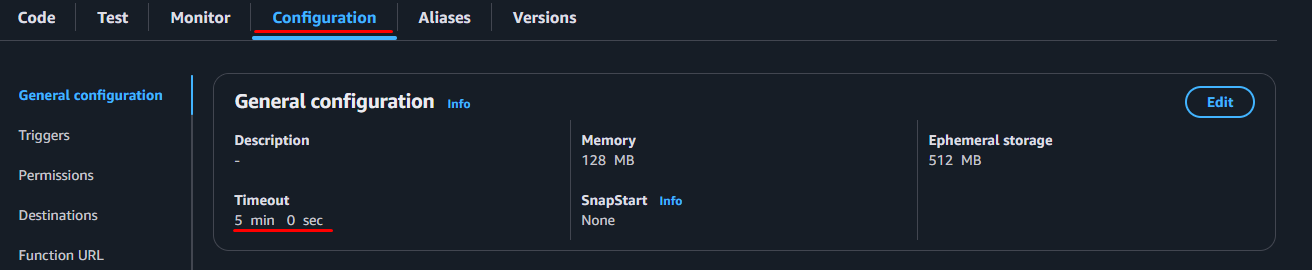

 - **Camadas**

Por fim, note que o código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do `AWS Lambda` possui poucos pacotes externos instalado, como o pacote Python boto3, logo o PyArrow não será encontrado e a execução da função falhará. Resolveremos isso adicionando uma layer ao nosso lambda, como estou utilizando o Python 3.12 utilizarei uma layer com uma versão compatível.

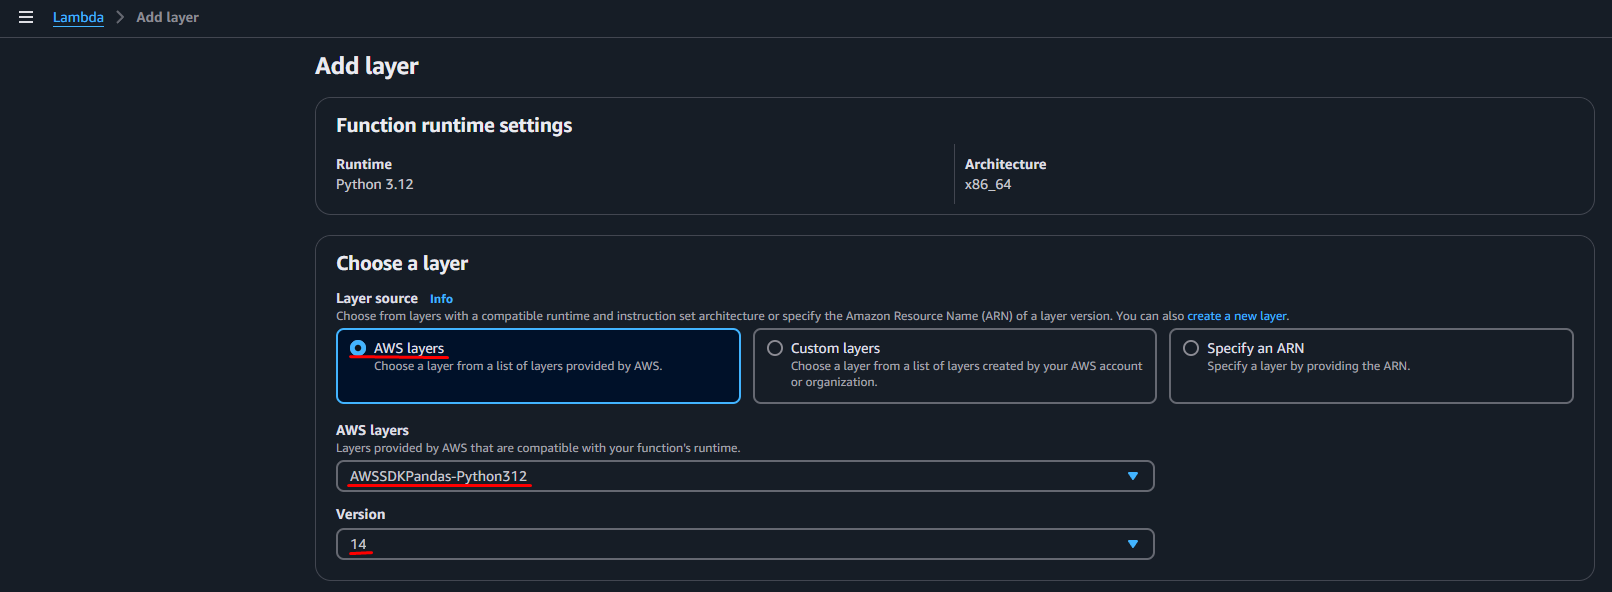

### III. AWS Event Bridge

O `AWS Event Bridge` terá a função de ativar diariamente a função de **ETL** do `AWS Lambda`, funcionando assim como um *scheduler*, sempre no intervalo D-1(Dia anterior)

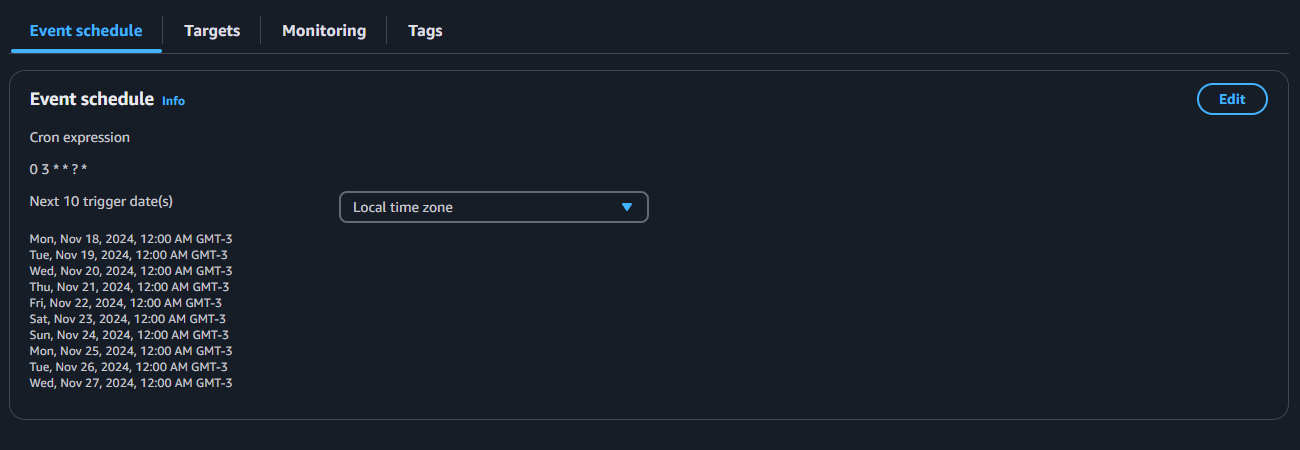

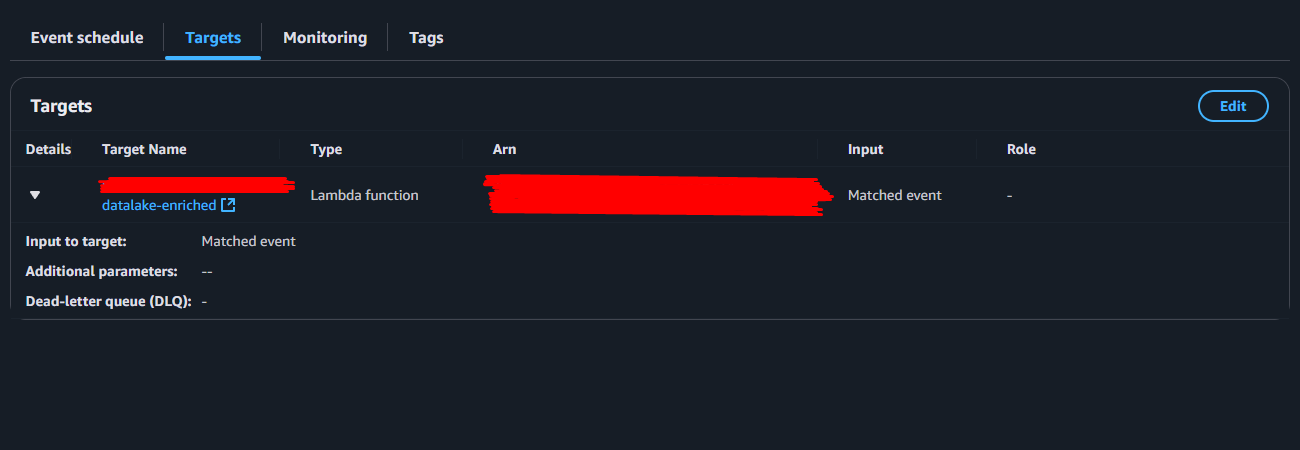

## 4\. Apresentação

A etapa de **apresentação** é reponsável por entregar o dado para os usuários (analistas, cientistas, etc.) e sistemas (dashboards, motores de consultas, etc.), idealmente através de uma interface de fácil uso, como o SQL, logo, essa é a única etapa que a maioria dos usuários terá acesso.

### I. AWS Athena

Na etapa de **apresentação**, o `AWS Athena` tem função de entregar o dados através de uma interface SQL para os usuários do sistema analítico. Para criar a interface, basta criar uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida. Precisaremos executar esse código abaixo para a criação de uma nova tabela para que possamos analisar os resultados:

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint, 
  `user_id` bigint, 
  `user_is_bot` boolean, 
  `user_first_name` string, 
  `chat_id` bigint, 
  `chat_type` string, 
  `text` string, 
  `date` bigint)
PARTITIONED BY ( 
  `context_date` date)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'
```

Por fim, sempre que uma nova partição for adicionada precisaremos executar o código abaixo:

```sql
MSCK REPAIR TABLE `telegram`;
```

Podemos consultas as 10 primeiras linhas para observar o resultado.

```sql
SELECT * FROM `telegram` LIMIT 10;
```

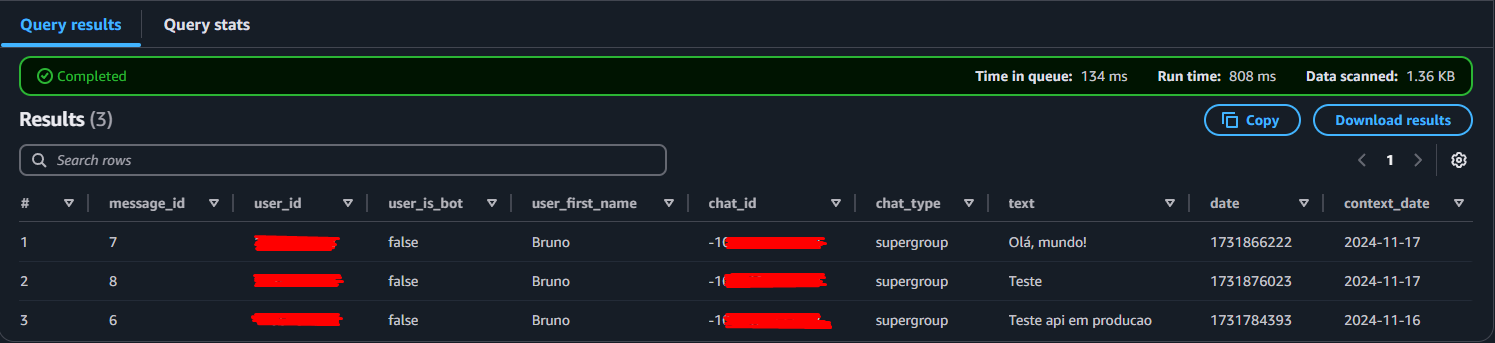